# MSc in AI 
# CE6002 & CS5062 Etivity 1 - EDA & The Learning Problem

## Student Name: Mark Murnane
## Student ID: 18195326

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

## Task 1

Load *bank_et1.csv* into a Pandas dataframe and data some basic data exploration.

Examine the first few data rows and last few data rows.

In [3]:
dataframe = pd.read_csv('bank_et1.csv', header=0, index_col=0)
dataframe.head()

,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,32,technician,single,tertiary,no,392,1.300134,0.473895,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,39,technician,divorced,secondary,no,688,-0.193701,0.237021,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,59,retired,married,secondary,no,1035,1.334266,0.121981,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,47,blue-collar,married,secondary,no,398,0.362286,1.251328,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,54,retired,married,secondary,no,1004,0.072075,-0.533738,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [4]:
dataframe.tail()

,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,20,student,single,NaN,no,2785,-2.170524,1.081071,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,28,admin.,single,secondary,no,127,0.811788,1.134496,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,81,retired,married,primary,no,1154,0.504655,0.042190,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,46,services,married,primary,no,4343,-0.965874,0.302708,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,40,entrepreneur,married,secondary,no,6403,-0.800893,1.066659,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


**Target Variable**

_Identify an attribute that can be the target variable for 2-class classification._

For a target variable to be useful in 2-class classification, it should be:
 - Something that is categorical in nature.
 - An attribute with 2 values
 - Have no missing values in the sample space

Examining the categorical data using the `describe()` method wil yield a count of the unique values in the categorical data, and a textual representation of the distribution of values.

In [5]:
# Describe the categorical attributes.  The unique value count is important here.
dataframe.describe(exclude=[np.number])

,job,marital,education,default,housing,loan,contact,month,poutcome,subscribed
count,1990,2000,1896,2000,2000,2000,1809,2000,1546,2000
unique,11,3,3,2,2,2,2,12,3,2
top,management,married,secondary,no,no,no,cellular,feb,failure,yes
freq,461,1111,995,1985,1037,1750,1663,404,955,1000


From the data above there are only 4 values that meet these requirements:
    
    - Default
    - Housing
    - Loan
    - Subscribed
    
Based on the distriubtion of values, it appears default is not a good target variable for training as the "No" values represents 99.25% of the samples.  

Of these attributes, the housing, loan and default attributes could be reasonably said to be descriptors of customers.  As a result the  _"Subscribed"_ attribute is the most likely candidate for the target/dependable variable.  
    

### Task 2

#### Statistics for Numerical and categorical variables

The Pandas Dataframe `describe()` function outputs statistics for the columns in the dataframe.  By default these are for numerical values only, however the _include_ parameter allows for specification of which type(s).

In [7]:
# Calling describe separately for numerical and categorical attributes for ease of reading
dataframe.describe(include=[np.number])

,age,balance,ratio_bal_ln,ratio_ln_inc,day,duration,campaign,pdays,previous
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.751500,1413.663500,0.241951,0.485030,13.851500,292.020500,1.909500,167.896000,2.561500
std,12.723077,3131.224213,0.821604,1.075543,9.712189,221.557295,1.378862,131.754126,3.400735
min,18.000000,-980.000000,-2.632068,-2.851405,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,32.000000,201.500000,-0.308018,-0.274181,5.000000,146.000000,1.000000,75.750000,1.000000
50%,38.000000,551.000000,0.224099,0.487082,12.000000,236.000000,1.000000,182.000000,2.000000
75%,50.000000,1644.500000,0.806315,1.211896,23.000000,379.000000,2.000000,251.000000,3.000000
max,93.000000,81204.000000,2.961979,4.046914,31.000000,1823.000000,11.000000,854.000000,55.000000


The statistics above show:

 - All numerical values are present in all samples (contrast to categorical)
 - The Age, Ratio_Bal_in and ratio_In_inc all have a mean and median that are relatively close, perhaps normally distributed.
 - The Balance attribute has a high mean vs. median so perhaps is skewed by a few high balance figures.
 - The Campaign attribute appears to be categorical rather than ordinal.

In [8]:
# Describe the categorical attributes.  The unique value count is important here.
dataframe.describe(exclude=[np.number])

,job,marital,education,default,housing,loan,contact,month,poutcome,subscribed
count,1990,2000,1896,2000,2000,2000,1809,2000,1546,2000
unique,11,3,3,2,2,2,2,12,3,2
top,management,married,secondary,no,no,no,cellular,feb,failure,yes
freq,461,1111,995,1985,1037,1750,1663,404,955,1000


The statistics above show:

 - Some attributes have gaps in the sample space where no data is present.  These may need to be accounted for (notably poutcome).
 - There are multiple _binary_ variables that could be candidates for simple classification.


### Plots

#### Numerical Data

For numerical data, a histogram is a useful univariate plot for an individual attribute.

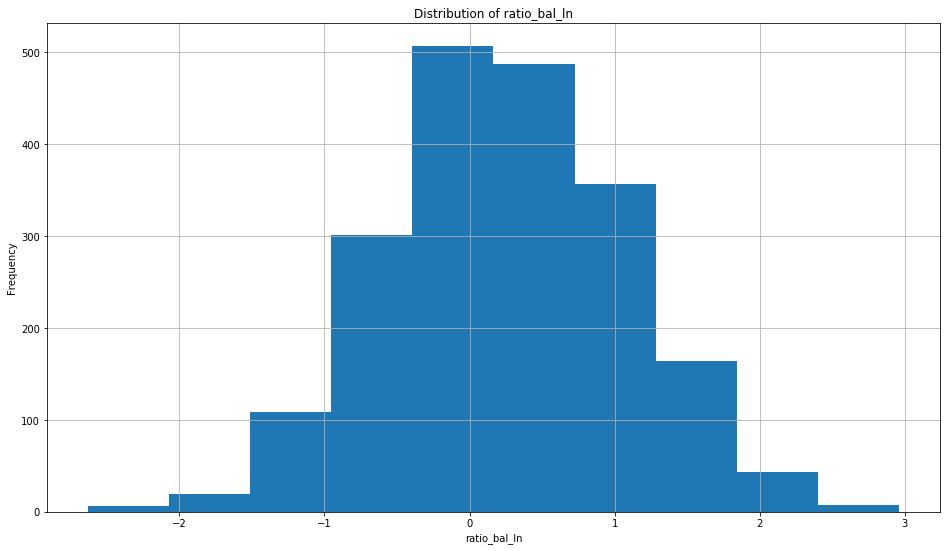

In [44]:
dataframe['ratio_bal_ln'].hist()
plt.title('Distribution of ratio_bal_ln')
plt.xlabel('ratio_bal_ln')
plt.ylabel('Frequency')
plt.show()

As suggested by the similarity between Mean and Median, the ratio_bal_ln values appear to be uniformly distributed.  This is important as many ML algorithms assume such a distribution.

D:\Masters\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


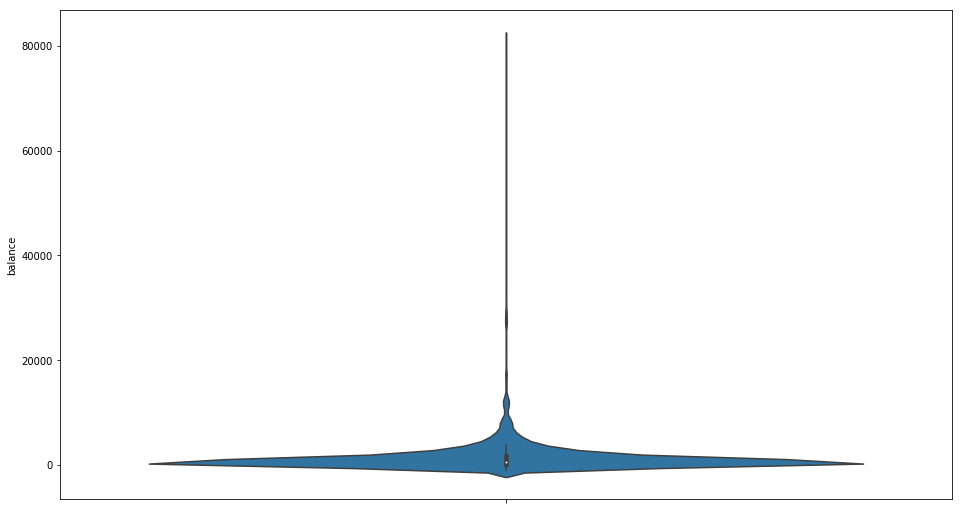

In [43]:
# Violin plot for Balance
# Note that difference between Mean and Median suggested a skew in data
sns.violinplot(y=dataframe['balance'])
plt.show()

The Violin Plot shows a significant range of values.  The concentration of values at < 25% of the range suggests the mean value is being dominated by a small number of very high balance values.  The actual number is not clear form the Violin Plot and a different visualisation might give a better insight.

The plot confirms, however, that some level of normalisation would be required on this value for learning as the high values could dominate/skew model learning.


#### Categorical Data

For categorical data a Bar Chart is a appropriate to visualise the distribution of values.


In [22]:
dataframe['job'].head(2)

0    technician
1    technician
Name: job, dtype: object

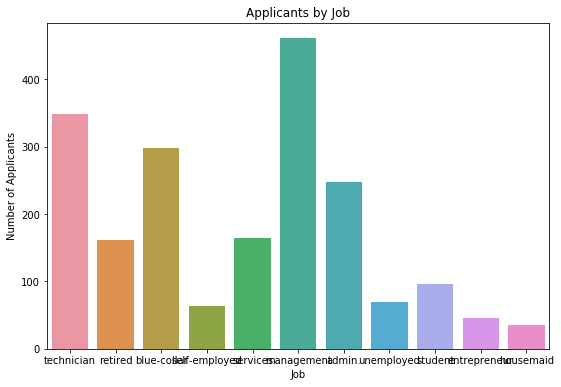

In [27]:
#dataframe['job'].plot(kind='bar')
sns.countplot(x='job', data=dataframe)
plt.title('Applicants by Job')
plt.xlabel('Job')
plt.ylabel('Number of Applicants')
plt.rcParams["figure.figsize"] = (16,9)
plt.show()

For the jobs category, the bar plot shows us that there are 4 job roles that represent over 50% of the applications.

#### Plots of 2 Attributes

Another useful plot for categorical data is a stacked chart of multiple categorical variables, e.g. job role and education.

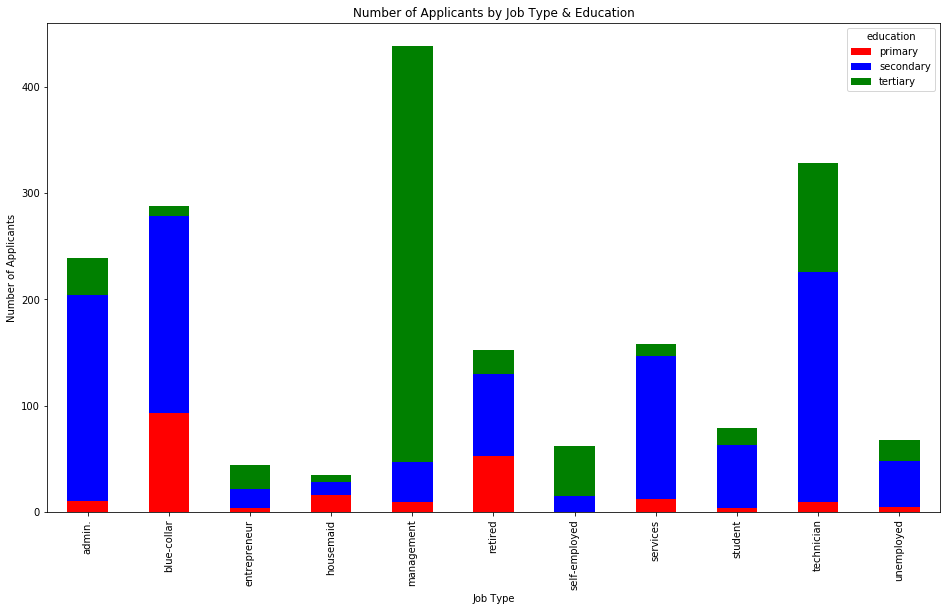

In [33]:
stacked = pd.crosstab(dataframe['job'], dataframe['education'])
stacked.plot(kind='bar', stacked=True, color=['red', 'blue', 'green'])
plt.ylabel('Number of Applicants')
plt.xlabel('Job Type')
plt.title('Number of Applicants by Job Type & Education')
plt.show()

From this plot we can easily visualise the level of educational attainment of the applicants (e.g. low number of primary only) but also easily visualise the distribution of educational levels within each job.

For a slightly different view on applicants, we can use a boxplot to look at balance by applicant job type.

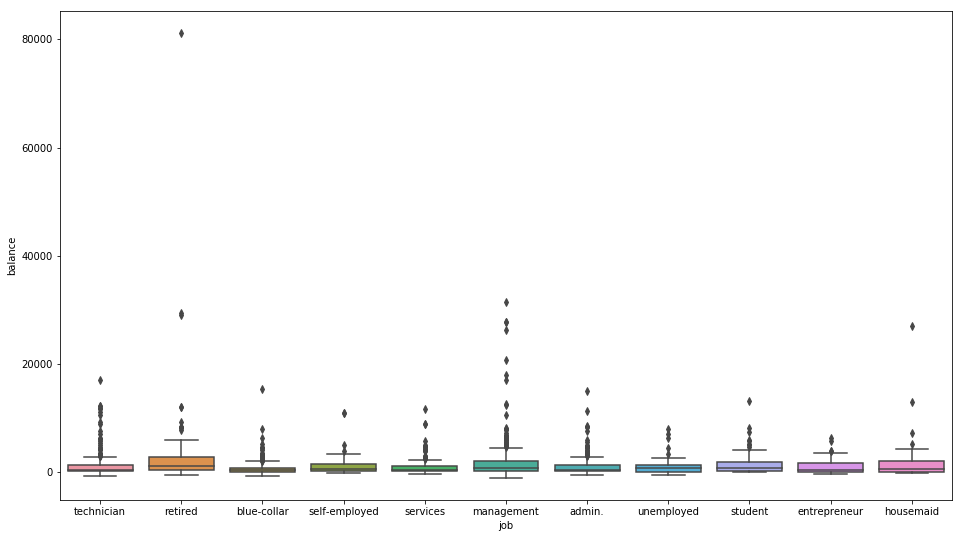

In [42]:
sns.boxplot(x='job', y='balance', data=dataframe)
plt.show()

This combined box plot gives us a greater insight into outliers that were noted earlier when just looking at the balance attribute in isolation.  

With a plot that combines attributes such as this, we gain an insight that might cause us to treat outliers differently, e.g. simple removal of that individual sample as it is in a category that we may not be focused on.

#### Numerical associations

One of the most usual ways to determine an association between variables is a plot.

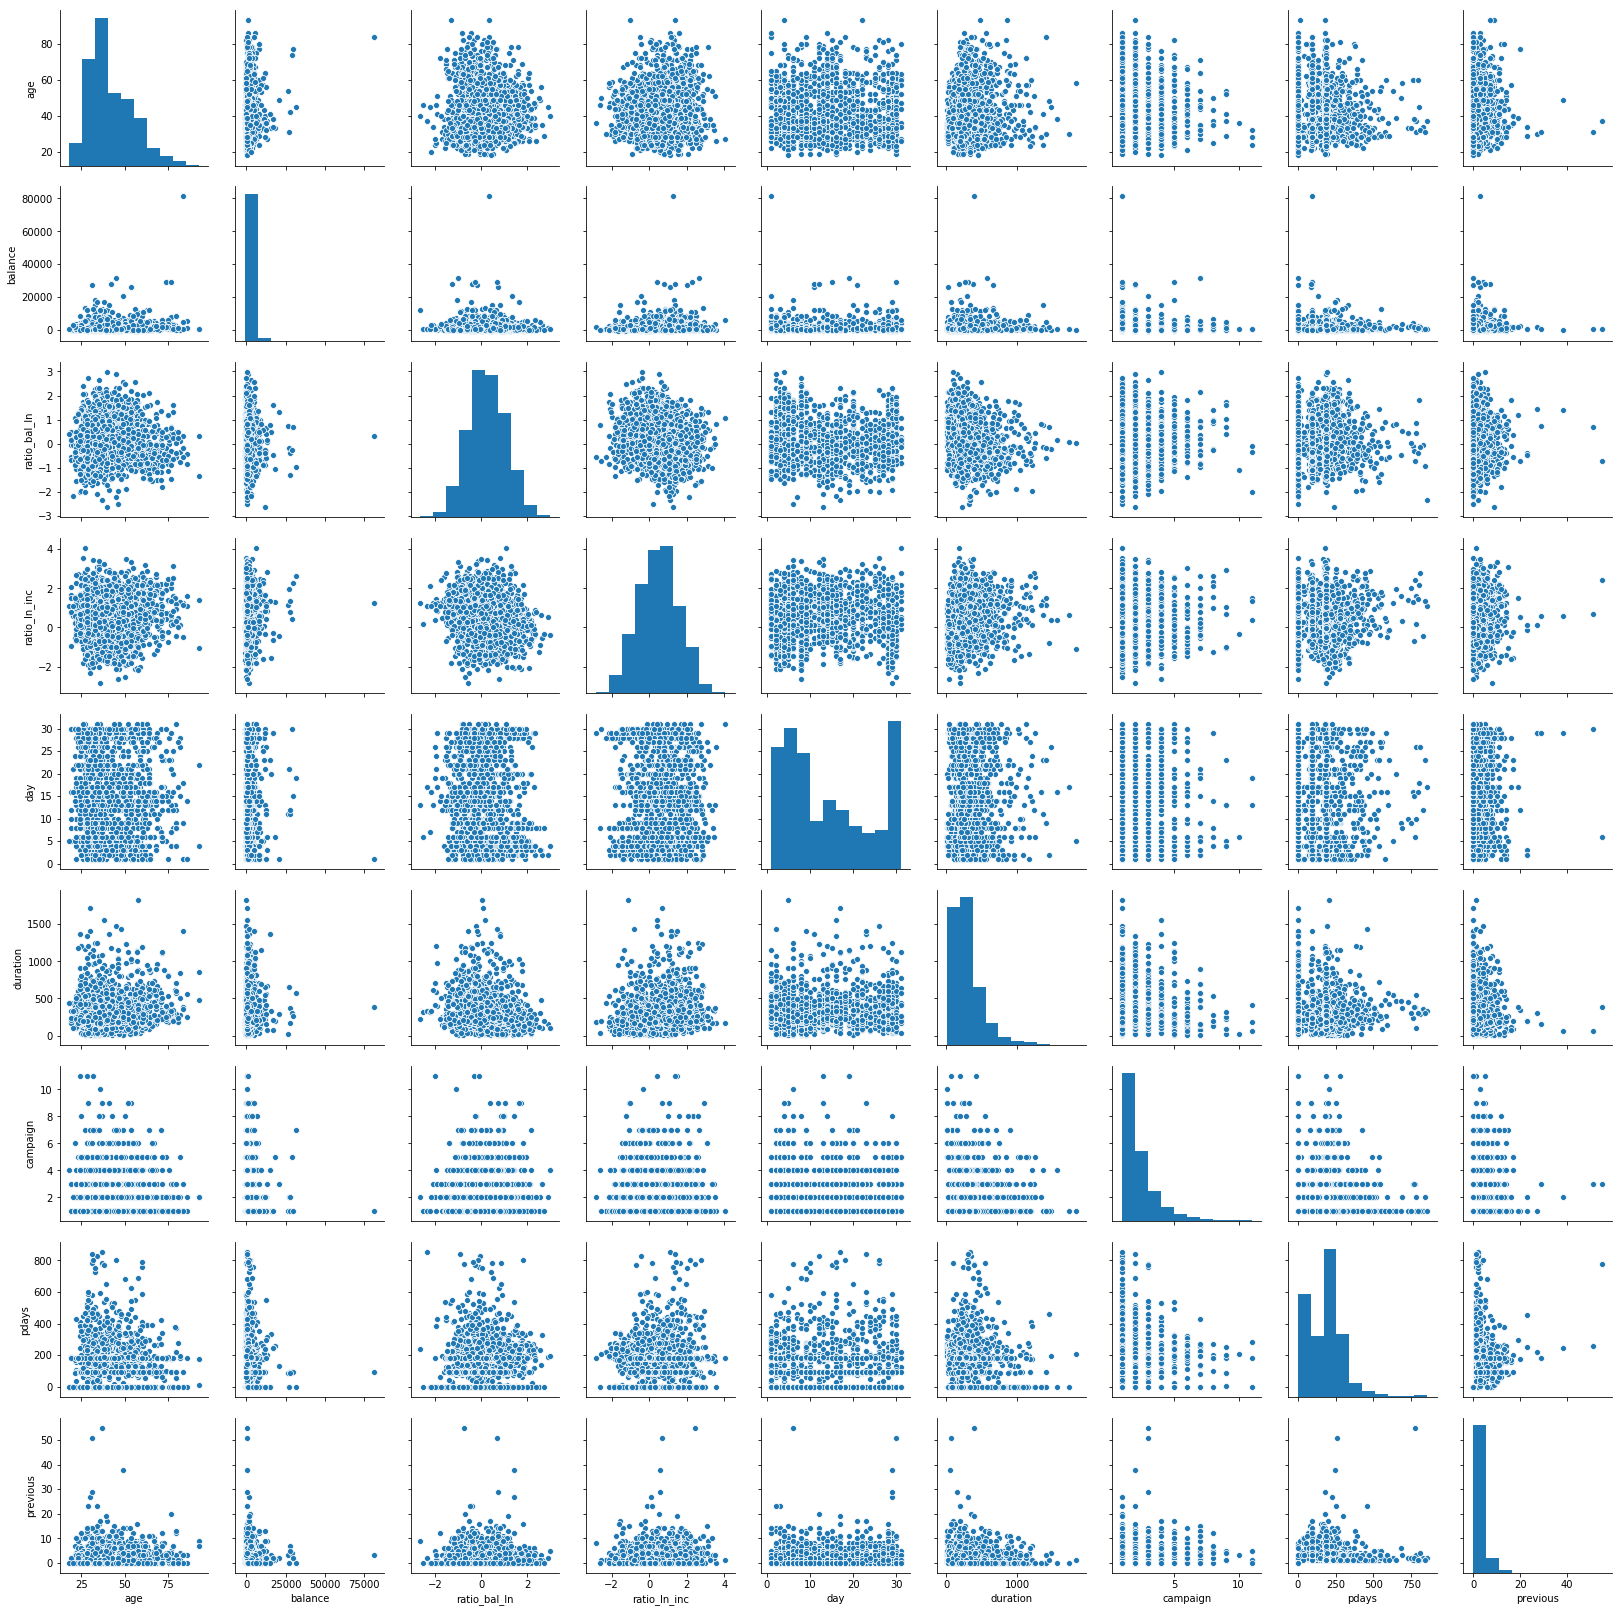

In [61]:
sns.pairplot(dataframe)
plt.show()

This pairplot doesn't seem to give much indication of what variables might be seperable or correlated.  It might require more specific comparison of values.

#### Predictive Variables

Pending some visualisation that hints at appropriate predictor attributes, I'll initially select ratio_bal_ln and age as predictors for the subscribed column.

Looking at the other numeric variables, many of them appear to be ambiguous:

 - ratio_inc_ln is not clearly linked to other attributes.  There is no income figure and no loan figure on which to base a hypothesis.
 - duration and pdays have no obvious definition
 - campaign is categorical in nature
 - In the absence of a year, the days value doesn't allow us to infer anything about day of week, and could represent any time
 
 

## Task 3

A perceptron can be used to perform 2-class classification by identifying a function that will map a set of attributes from a 
data set to one of 2 values (the classes). 

In the context of the selections above, the Perceptron would attempt to identify a  function that successfully maps the values of _age_ and *ratio_bal_ln* to the target attribute _subscribed_.  All of the possible values of the attributes and their combinations represent the **_Input space_** to the function.  The number of attributes defines the dimensionality of the input set.   All of the possible values of _subscribed_ would represent the **_Output space_**.  As this is a 2-class classification the output would be a 1-d space with two values ('yes'/'no').

The sample **_Data Set_** is a subset of the _Input space_ and contains the value of each attribute for a number of observations.

Note that other attributes may be included in the Input space, or excluded if Exploratory Data Analysis indicates they are not descriptive of the classification or otherwise significant.

Theoretically there a single **_unknown target function_** that perfectly maps the values of _age_ and *ratio_bal_ln* from the input space to the output space.  Generally though is a set of potential functions that might perform this mapping.  These form the **_Hypothesis set_** of the problem.    The role of the Perceptron is to narrow down the Hypothesis set and select a **_Final Hypothesis_** that approximates the _unknown target function_ as closely as possible, given limits on the size of the Data and Hypotheses sets.


To determine the _Final Hypothesis_ the Perceptron evaluates each hypothesis based on the number of prediction errors in the data set.  These **_In-sample Errors_** are reduced by adjusting the weights and bias the Perceptron applies to the _Data set_.  

Ultimately the usefulness of the _Final Hypothesis_ is the **_Out-of-sample_** error rate, or the probability that it will incorrectly classify unseen data from the _Input space_.  Practically training has to be limited to a data set but we can use the **_Hoeffding Inequality_** to infer the _Out-of-sample_ error.  This provides a means to determine the accuracy of a given hypothesis, or inveserly to determine who many samples are required to reach a certain level of accuracy.

## For Task 4 ...

Suggestion: try PLA on this dataset before using the bank dataset

In [3]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2)
y = [yy if yy == 1 else -1 for yy in y] 

In [4]:
def h(x,w):
    #Perceptron model: the sign of the dot product of weights and input vector determines the class allocation
    bias = np.array([1])
    return np.sign(w.T.dot(np.concatenate((bias,x))))

In [5]:
def point_on_boundary(weights, x):
    # Return the y-position on the boundary based on given x-position
    return -(weights[0]+weights[1]*x)/weights[2]

In [6]:
def decision_boundary(weights, x_min, x_max):
    # Return two points on the decision boundary
    return [pointOnBoundary(x_min), pointOnBoundary(x_max)]

In [7]:
def pla(training_in, training_out, weights):
    bias = np.array([1])
    iterations=0
    while True:
        errors = 0;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)!=y):
                iterations+=1;
                weights = weights + y*(np.concatenate((bias,x)))
                errors+=1;
        if (errors == 0):
            break
    return weights, iterations

In [8]:
def calc_error(training_in, training_out, weights):
    # Calculate the classification error as the fraction of training samples that are misclassified
    errors=0
    for x,y in zip(training_in, training_out):
        if (h(x,weights)!=y):
            errors+=1;
    return errors/len(training_in)